In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

modelpath="mistralai/Mistral-7B-v0.1"

# Load 4-bit quantized model
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
)

# Load (slow) Tokenizer, fast tokenizer sometimes ignores added tokens
tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)   

tokenizer.pad_token = "</s>"
model.resize_token_embeddings(len(tokenizer))
model.config.eos_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

## Dataset

In [6]:
def tokenize_game(game, tokenizer):
    inputs = tokenizer(text=game, return_tensors="pt", truncation=True, max_length=512 * 3, pad_to_multiple_of=256)

    return inputs

def add_comment_mask(inputs, opening_bracket_id, closing_bracket_id):
    mask = []

    is_inside = False
    for token in inputs.input_ids[0]:
        if token == opening_bracket_id:
            mask.append(False)
            is_inside = True
        elif token == closing_bracket_id:
            mask.append(True)
            is_inside = False
        else:
            mask.append(is_inside)

    inputs["comment_mask"] = torch.tensor(mask).to(inputs.input_ids.device)
    inputs["input_ids"] = inputs["input_ids"].squeeze()
    inputs["attention_mask"] = inputs["attention_mask"].squeeze()

    return inputs

In [7]:
import chess.pgn
from torch.utils.data import Dataset, DataLoader

class ChessCommmentDataset(Dataset):
    def __init__(self, path_to_pgn: str, tokenizer):
        """
        A dataset of chess games with comments. Each sample is a game in PGN format with textual comments.

        path_to_pgn: str
            Path to a single pgn with all games.
        tokenizer:
            Tokenizer used to convert all strings into tokens.
        """
        self.path_to_pgn = path_to_pgn
        self.game_offsets = []
        self.games = []

        with open(path_to_pgn) as pgn:
            while True:
                offset = pgn.tell()
                game = chess.pgn.read_game(pgn)

                if game is None:
                    # End of the file (or error)
                    print(f"Scanned {len(self.game_offsets)} games")
                    break

                self.game_offsets.append(offset)
                self.games.append(str(game.mainline()) + " Result: " + str(game.headers["Result"]))

        closing_bracket_id = tokenizer("}", add_special_tokens=False).input_ids[0]
        opening_bracket_id = tokenizer("{", add_special_tokens=False).input_ids[0]

        self.games = [
            add_comment_mask(tokenize_game(game, tokenizer), opening_bracket_id, closing_bracket_id) for game in self.games
        ]

    def __getitem__(self, index):
        return self.games[index]
        
    def __len__(self):
        return len(self.game_offsets)

In [8]:
dataset = ChessCommmentDataset("data/famous_games.pgn", tokenizer)

Scanned 500 games


In [9]:
sample = dataset[15]

for i in range(sample.input_ids.shape[-1]):
    wordpiece = tokenizer.decode(sample.input_ids[i], add_special_tokens=False)
    
    print(f"Token: {sample.input_ids[i].item():6}  Wordpiece: {wordpiece:5}  Is comment: {sample.comment_mask[i].item()}")

Token:      1  Wordpiece: <s>    Is comment: False
Token:  28705  Wordpiece:        Is comment: False
Token:  28740  Wordpiece: 1      Is comment: False
Token:  28723  Wordpiece: .      Is comment: False
Token:    317  Wordpiece: e      Is comment: False
Token:  28781  Wordpiece: 4      Is comment: False
Token:    317  Wordpiece: e      Is comment: False
Token:  28782  Wordpiece: 5      Is comment: False
Token:  28705  Wordpiece:        Is comment: False
Token:  28750  Wordpiece: 2      Is comment: False
Token:  28723  Wordpiece: .      Is comment: False
Token:    418  Wordpiece: N      Is comment: False
Token:  28722  Wordpiece: f      Is comment: False
Token:  28770  Wordpiece: 3      Is comment: False
Token:    418  Wordpiece: N      Is comment: False
Token:  28717  Wordpiece: c      Is comment: False
Token:  28784  Wordpiece: 6      Is comment: False
Token:  28705  Wordpiece:        Is comment: False
Token:  28770  Wordpiece: 3      Is comment: False
Token:  28723  Wordpiece: .    

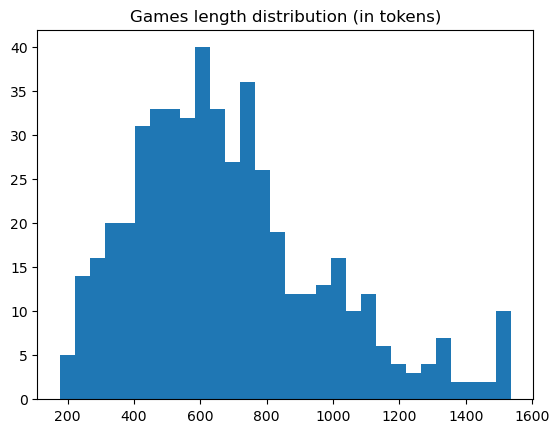

In [10]:
import matplotlib.pyplot as plt

lengths = [sample.input_ids.shape[-1] for sample in dataset]
plt.hist(lengths, bins=30)
plt.title("Games length distribution (in tokens)")
plt.show()

In [11]:
# Find out what we should use as padding value
tokenizer.pad_token_id

2

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collator(examples):
    """
    Takes a list of dicts, returns a dict of padded tensors. 
    """
    batch_keys = examples[0].keys()
            
    return {key: pad_sequence([sample[key] for sample in examples], batch_first=True, padding_value=2 if key == "input_ids" else 0)
            for key in batch_keys}

In [13]:
batch = collator(
    [dataset[0], dataset[1], dataset[2]]
)

In [14]:
batch

{'input_ids': tensor([[    1, 28705, 28740,  ..., 28734, 28733, 28740],
         [    1, 28705, 28740,  ...,     2,     2,     2],
         [    1, 28705, 28740,  ...,     2,     2,     2]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'comment_mask': tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]])}

## Configure training

In [15]:
# Add LoRA adapters to model
model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=4, 
    lora_alpha=16, 
    target_modules = ['q_proj', 'k_proj', 'down_proj', 'v_proj', 'gate_proj', 'o_proj', 'up_proj'],
    lora_dropout=0.1, 
    bias="none", 
    #modules_to_save = ["lm_head", "embed_tokens"],		# needed because we added new tokens to tokenizer/model
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, config)
model.config.use_cache = False

In [19]:
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("input_ids")
        comment_mask = inputs.pop("comment_mask")
        outputs = model(**inputs)

        # criterion = nn.CrossEntropyLoss(reduction="none")
        # loss = (criterion(outputs.logits.transpose(1,2), labels) * comment_mask).sum() / (comment_mask.sum() + 1e-3)
        criterion = nn.CrossEntropyLoss(reduction="mean")
        loss = criterion(outputs.logits.transpose(1,2), labels) 

        return (loss, outputs) if return_outputs else loss

In [20]:
batch_size = 2
epochs = 1
gradient_accumulation_steps = 1
steps_per_epoch = len(dataset) // (batch_size * gradient_accumulation_steps)

args = TrainingArguments(
    output_dir="results",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #evaluation_strategy="steps",
    logging_steps=1,
    #eval_steps=steps_per_epoch,		# eval and save once per epoch  	
    save_steps=steps_per_epoch,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",
    learning_rate=2e-6,
    group_by_length=True,
    fp16=True,
    ddp_find_unused_parameters=False,
)

In [21]:
trainer = CustomTrainer(
#trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=collator,
    train_dataset=dataset,
    #eval_dataset=dataset_tokenized["test"],
    args=args,
)

trainer.train()

/home/seleznyov/micromamba/envs/stein/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,13.731100
2,14.114200
3,13.971200
4,13.649000
5,13.938700
6,13.666200
7,13.393300
8,13.735400
9,13.543100
10,13.330100


TrainOutput(global_step=250, training_loss=6.445546573042869, metrics={'train_runtime': 506.4439, 'train_samples_per_second': 0.987, 'train_steps_per_second': 0.494, 'total_flos': 1.4811356719644672e+16, 'train_loss': 6.445546573042869, 'epoch': 1.0})

## Testing

In [22]:
closing_bracket_id = tokenizer("}", add_special_tokens=False).input_ids[0]
closing_bracket_id

443

In [23]:
from tqdm.auto import tqdm

def comment_chess_game(move_sequence, prompt, model, tokenizer, device, max_comment_size=40):
    """
    Input:
        move_sequence: List[str], 
            A sequence of moves from White and Black in PGN format. Moves for White also include the move number. Comments and NAGs are excluded.
            example: ["1. e4 ", "e5 ", "2. Qh5 ", "Nc6 ", "3. Bc4 ", "Nf6 ", "4. Qxf7#"]
        prompt: str
            Prompt used to incentivize the model to provide coherent comments
        model: transformers.AutoModelForCausalLM
            A model to generate comments (e.g. Mistral 7B).
        tokenizer: transformers.AutoTokenizer
            Corresponing tokenizer

    Output:
        commented_game: str
            A single string with all moves and occasional comments, hopefully in PGN format.
    """
    prefix = prompt
    game = prompt

    for move in tqdm(move_sequence, desc="Moves"):
        prefix += move
        # to initialize a comment
        prefix += "{ "

        print(move)
        
        inputs = tokenizer(prefix, return_tensors="pt").to(device)
        output = model.generate(**inputs, eos_token_id=closing_bracket_id, pad_token_id=closing_bracket_id, min_new_tokens=max_comment_size//4, max_new_tokens=max_comment_size)
        comment = tokenizer.decode(output[0, inputs.input_ids.shape[-1]:], skip_special_tokens=True)

        prefix += comment
        print("Comment:", comment)
        print("=" * 25)

    return prefix

In [24]:
prompt = """Several chess games with concise comments, which briefly explain the upsides and downsides of the move \
(e.g. whether it develops a piece, wins material, brings king to safety, puts a piece to a better/worse square, creates a threat, fails to pary on opponents idea).
Comment is as always succint as possible -- e.g. { Develops a knight and controls the center. }, or { Wins a pawn, but loses a tempo. } or { Creates a checkmating threat. }.
Comment always focuses on pros and cons of the move, or on the idea/reasoning behind it.
Each comment always starts with an opening curly bracket '{' and ends with a closing curly bracket '}'.

Game 1:
"""

In [25]:
game = ["1. f3 ", " e5 ", " 2. g4 ", " Qh4# "]

commented_game = comment_chess_game(game, prompt, model, tokenizer, device)

Moves:   0%|          | 0/4 [00:00<?, ?it/s]

1. f3 


/home/seleznyov/micromamba/envs/stein/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/seleznyov/micromamba/envs/stein/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/seleznyov/micromamba/envs/stein/lib/

Comment:                                       
 e5 
Comment:                                       
 2. g4 
Comment:                                       
 Qh4# 
Comment:                                       


In [26]:
game = ["1. e4 ", " e5 ", " 2. Qh5 ", " Nc6 ", " 3. Bc4 ", " Nf6 ", "4. Qxf7# "]

commented_game = comment_chess_game(game, prompt, model, tokenizer, device)

Moves:   0%|          | 0/7 [00:00<?, ?it/s]

1. e4 
Comment:                                       
 e5 
Comment:                                       
 2. Qh5 
Comment:                                       
 Nc6 
Comment:                                       
 3. Bc4 
Comment:                                       
 Nf6 
Comment:                                       
4. Qxf7# 
Comment:                                       
